# Testing LLaVA


In [1]:
#must use python 3.10 for this projcet. will also need to delete old conda envs in the morning
#This cell is a hugging face sanity check
#idea use clip to fectch t20 photos matching a user description use LLava to generate captions for 20 photos vector embeded them and compare to original prompt for similarity. 
#https://grok.com/share/c2hhcmQtMg%3D%3D_36b5ade9-4791-401a-86bf-3cf9eb29e0fa

import torch
import accelerate
from transformers import AutoProcessor, LlavaForConditionalGeneration
### This cell is bassically a sanity check to ensure conda works. 

# Load the model in half-precision
model = LlavaForConditionalGeneration.from_pretrained("llava-hf/llava-1.5-7b-hf", torch_dtype=torch.float16, device_map="auto")
processor = AutoProcessor.from_pretrained("llava-hf/llava-1.5-7b-hf", use_fast=True)

conversation = [
    {
        "role": "user",
        "content": [
            {"type": "image", "url": "https://www.ilankelman.org/stopsigns/australia.jpg"},
            {"type": "text", "text": "What is shown in this image?"},
        ],
    },
]

inputs = processor.apply_chat_template(
    conversation,
    add_generation_prompt=True,
    tokenize=True,
    return_dict=True,
    return_tensors="pt"
).to(model.device, torch.float16)
# Generate
generate_ids = model.generate(**inputs, max_new_tokens=30)
processor.batch_decode(generate_ids, skip_special_tokens=True)

2025-04-17 14:13:51.869073: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-17 14:13:51.904940: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-17 14:13:51.904967: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-17 14:13:51.906108: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-17 14:13:51.912564: I tensorflow/core/platform/cpu_feature_guar

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

['USER:  \nWhat is shown in this image? ASSISTANT: The image shows a street scene with a stop sign, a lion statue, and a red building. There is also a car driving down the street']

# CLIP


In [2]:
from MemoryRetrieval import *
# getting image paths
import os
## Load LLava model
LLava_image_dir = "T20photos"
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
##Model setup
llava_model = LlavaForConditionalGeneration.from_pretrained("llava-hf/llava-1.5-7b-hf", torch_dtype=torch.float16).to(device)
processor = AutoProcessor.from_pretrained("llava-hf/llava-1.5-7b-hf", use_fast=True)
clip_model, clip_preprocess = clip.load("ViT-B/32", device="cpu")

# Define the base directory where your images are stored
image_dir = "./pisc2000plusUs"

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
## Pre compute clip embeddings based on photo library so tht dir should be all the photos
from PIL import Image 

def encode_images(image_dir):
    image_embeddings = []
    image_paths = []
    
    for img_path in os.listdir(image_dir):
        img = Image.open(os.path.join(image_dir, img_path))
        img = clip_preprocess(img).unsqueeze(0).to("cpu")
        with torch.no_grad():
            emb = clip_model.encode_image(img).cpu().numpy()
        image_embeddings.append(emb)
        image_paths.append(img_path)
    
    # Build Faiss index
    image_embeddings = np.vstack(image_embeddings)
    index = faiss.IndexFlatL2(image_embeddings.shape[1])
    index.add(image_embeddings)
    
    return index, image_embeddings, image_paths

# clip encodes images
clip_index, clip_embeddings, image_paths = encode_images(image_dir)


# Facial Recognition



In [5]:
from facenet_pytorch import MTCNN, InceptionResnetV1

def user_in_image(img_path, thresh=1):
    mtcnn = MTCNN()
    resnet = InceptionResnetV1(pretrained="casia-webface").eval()

    baseImgWyatt = Image.open("./wyattFace.jpg")
    baseImgKevius = Image.open("./keviusFace.jpg")
    inputImg = Image.open(img_path)

    wyatt = mtcnn(baseImgWyatt)
    kevius = mtcnn(baseImgKevius)
    inputFace = mtcnn(inputImg)

    if wyatt is not None and kevius is not None and inputFace is not None:
        wyattEmbed = resnet(mtcnn(baseImgWyatt).unsqueeze(0)).detach()
        keviusEmbed = resnet(mtcnn(baseImgKevius).unsqueeze(0)).detach()
        inputEmbed = resnet(mtcnn(inputImg).unsqueeze(0)).detach()

        wyattDist = (wyattEmbed - inputEmbed).norm().item()
        keviusDist = (keviusEmbed - inputEmbed).norm().item()

        if wyattDist < thresh or keviusDist < thresh:
            return True
        else:
            return False
    else:
        return False

# LLava Step

Prompt: Could you find a photo of me and my family playing board games. I think it had a lot of plastic minifigures.
Image Path: 20231229_192445.jpg
CLIP Score: 0.049376726150512695
LLaVA Score: 0.6441665847743355
User's Face Detected: False
Final Image Score: 0.808550787344575
The Image: 



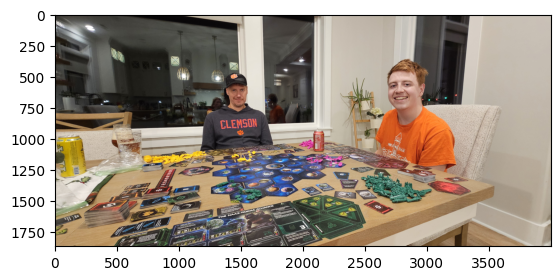

Image Path: 21273.jpg
CLIP Score: 0.049376726150512695
LLaVA Score: 0.6441665847743355
User's Face Detected: False
Final Image Score: 0.7727122259377813
The Image: 



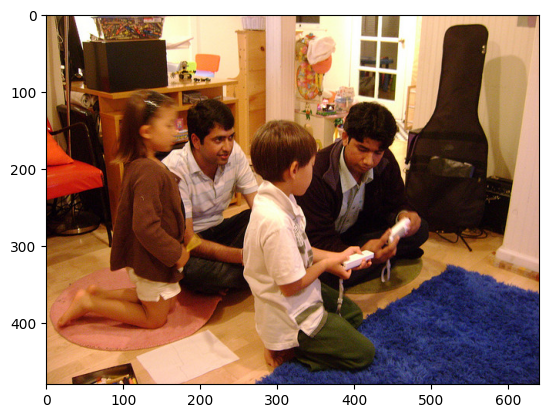

Image Path: 23122.jpg
CLIP Score: 0.049376726150512695
LLaVA Score: 0.6441665847743355
User's Face Detected: False
Final Image Score: 0.7535041053246488
The Image: 



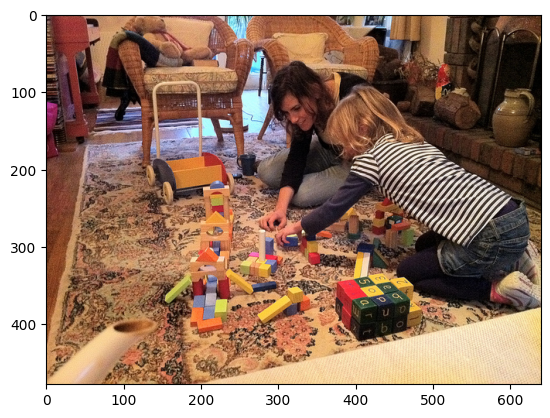

Image Path: 02723.jpg
CLIP Score: 0.049376726150512695
LLaVA Score: 0.6441665847743355
User's Face Detected: False
Final Image Score: 0.20773317581562414
The Image: 



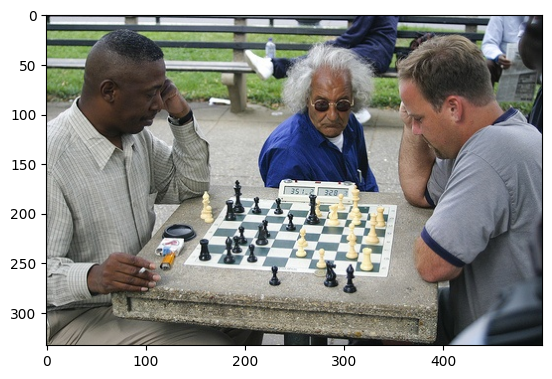

Image Path: 11125.jpg
CLIP Score: 0.049376726150512695
LLaVA Score: 0.6441665847743355
User's Face Detected: False
Final Image Score: 0.20170013784843893
The Image: 



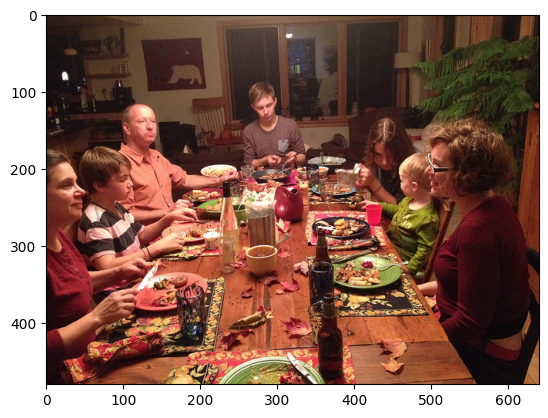

Image Path: 20231121_223520.jpg
CLIP Score: 0.049376726150512695
LLaVA Score: 0.6441665847743355
User's Face Detected: False
Final Image Score: 0.192033721802647
The Image: 



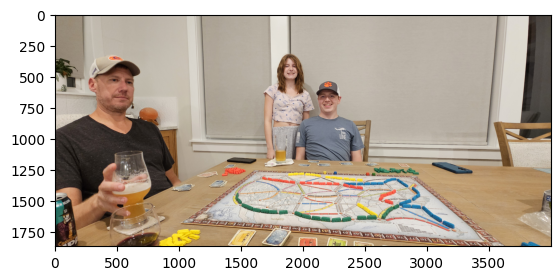

Image Path: 07353.jpg
CLIP Score: 0.049376726150512695
LLaVA Score: 0.6441665847743355
User's Face Detected: False
Final Image Score: 0.18821856206291687
The Image: 



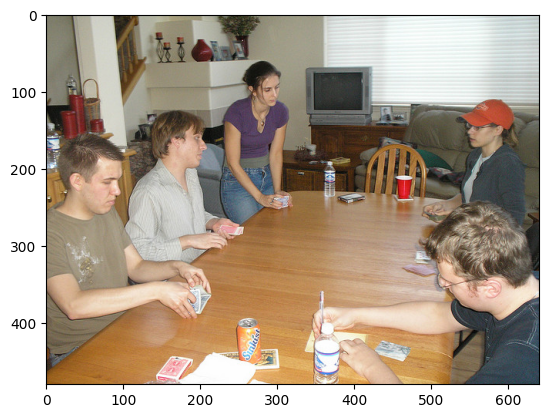

Image Path: 22990.jpg
CLIP Score: 0.049376726150512695
LLaVA Score: 0.6441665847743355
User's Face Detected: False
Final Image Score: 0.18500277921007596
The Image: 



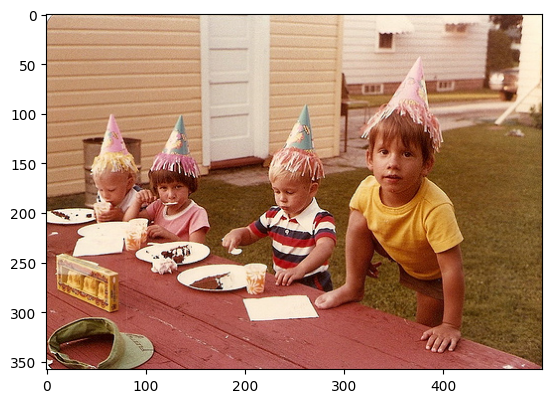

Image Path: 24195.jpg
CLIP Score: 0.049376726150512695
LLaVA Score: 0.6441665847743355
User's Face Detected: False
Final Image Score: 0.18413401555815445
The Image: 



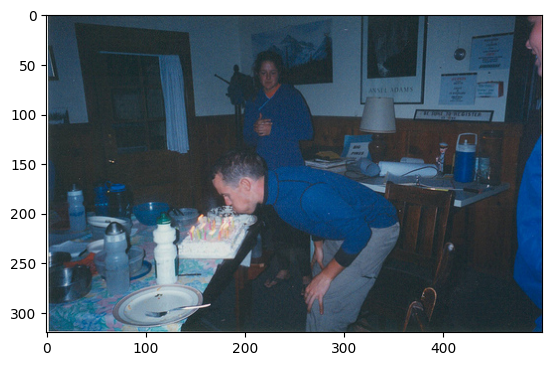

Image Path: 00268.jpg
CLIP Score: 0.049376726150512695
LLaVA Score: 0.6441665847743355
User's Face Detected: False
Final Image Score: 0.17364482250117214
The Image: 



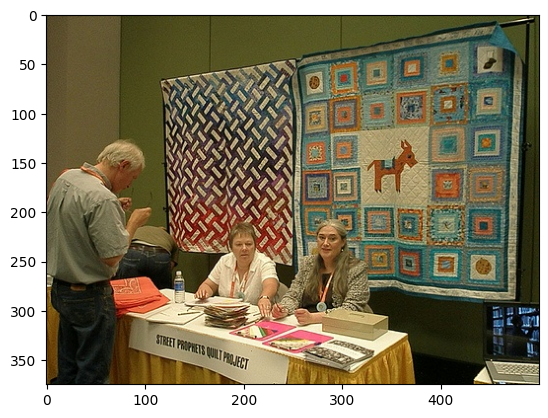

In [14]:
## a function that utilizes caption facial recognition and clip to score and output highest scoring image
def rank_photos(prompt, n=10, prio_user=True, user_weight=0.6):
    #retrieve initial batch of photos with CLIP
    prompt_emb = clip_model.encode_text(clip.tokenize([prompt]).to("cpu")).detach().cpu().numpy()
    distances, indices = clip_index.search(prompt_emb, n*2)
    clip_scores = 1 - distances[0] / np.max(distances[0]) #normalize to be between 0-1
    # LLava Captions photos and compuites a similarity score.
    llava_scores = []
    captions = []
    for idx in indices[0]:
        img_path = os.path.join(image_dir, image_paths[idx])
        caption = caption_image(Image.open(img_path).convert("RGB"), llava_model, processor)
        score = image_similarity(prompt, caption)
        llava_scores.append(score)
        captions.append(caption)
    llava_scores = np.array(llava_scores)
    llava_scores = llava_scores / np.max(llava_scores)  # Normalize
    
    # use facial recognition to computre probability of a user being in the photo
    user_present = [] #score of if user is present in photo
    for idx in indices[0]:
        img_path = os.path.join(image_dir, image_paths[idx])
        score = user_in_image(img_path) if prio_user else 0.0 #change this to whatever your function to calculate user dection is
        user_present.append(score)
    user_present = np.array(user_present)
    #score each image and output n images in descending order.
    image_scores = 0.4 * clip_scores + 0.2 * llava_scores + user_weight * user_present
    top_n_images = np.argsort(image_scores)[::-1][:n]
    
    results = []
    for i in top_n_images:
        idx = indices[0][i]
        results.append({
            "path": image_paths[idx],
            "caption": captions[i],
            "clip_score": clip_scores[i],
            "llava_score": llava_scores[i],
            "face_recognition_score": user_present[i],
            "final_score": image_scores[i]
        })
    return results

testPromptOne = "Could you find a photo of me and my family playing board games. I think it had a lot of plastic minifigures."
testPromptTwo = "Find a picture of me hiking with friends"

results = rank_photos(testPromptOne)
print(f"Prompt: {testPromptOne}")

for i in range(len(results)):
    path = results[i]["path"]
    #clipScore = results[i]["clip_score"]
    #llavaScore = results[i]["llava_score"]
    #faceScore = results[i]["face_recognition_score"]
    finalScore = results[i]["final_score"]
    
    image = Image.open(os.path.join(image_dir, results[i]["path"]))
    image.save(f"./results/result{i}.jpg")
    
    print(f"Image Path: {path}\nCLIP Score: {clipScore}\nLLaVA Score: {llavaScore}\nUser's Face Detected: {faceScore}\nFinal Image Score: {finalScore}\nThe Image: \n")
    plt.imshow(image)
    plt.show()

# results = rank_photos(testPromptTwo)
# print(f"\n\n\nPrompt: {testPromptTwo}")

# for i in range(len(results)):
#     path = results[i]["path"]
#     #clipScore = results[i]["clip_score"]
#     #llavaScore = results[i]["llava_score"]
#     #faceScore = results[i]["face_recognition_score"]
#     finalScore = results[i]["final_score"]
    
#     image = Image.open(os.path.join(image_dir, results[i]["path"]))
#     image.save(f"./results/result{i}_2.jpg")
    
#     print(f"Image Path: {path}\nCLIP Score: {clipScore}\nLLaVA Score: {llavaScore}\nUser's Face Detected: {faceScore}\nFinal Image Score: {finalScore}\nThe Image: \n")
#     plt.imshow(image)
#     plt.show()